In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import warnings
import pandas as pd
from binance.client import Client
from matplotlib.ticker import MultipleLocator

Valores Binance

In [8]:
api_key = 'e8n0UyRWAT0mp2tk4XPxQ4ARjsDVfBodiPqa2g4QAw6IL4KBEHznNOTExZimDDvZ'
api_secret = 'BQkCyvFh5Y2feKSiugiA8hqw4sNTdPUK3BFmzNKh70jt3AleAAzz4UZGF8yvzTWf'
symbol = 'BTCUSDT'
interval = '1d'

# Defina as datas de início e término
start_date = '2021-03-01'
end_date = '2023-10-31'

# Converta as datas para timestamps em milissegundos corretamente
start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

client = Client(api_key, api_secret)

# Inicialize uma lista para armazenar os dados
all_klines = []

# Número máximo de candles por solicitação (limitação da API Binance)
limit = 1000

# Faça chamadas repetidas para obter todos os dados
while True:
    # Obtenha o histórico de preços (candles) para o par de negociação e intervalo especificados
    klines = client.get_klines(symbol=symbol, interval=interval, startTime=start_timestamp, endTime=end_timestamp, limit=limit)

    # Adicione os dados à lista
    all_klines.extend(klines)

    # Se o número de candles retornados for menor que o limite, terminamos
    if len(klines) < limit:
        break

    # Atualize a data de início para a próxima chamada
    start_timestamp = int(klines[-1][0]) + 1

# Estrutura dos dados para DataFrame
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
df1 = pd.DataFrame(all_klines, columns=columns)
df1.drop(columns=['close_time', 'quote_asset_volume','number_of_trades','taker_buy_base_asset_volume','taker_buy_quote_asset_volume','ignore'], inplace=True)
# Converta os timestamps para formato legível
df1['timestamp'] = pd.to_datetime(df1['timestamp'], unit='ms')
df1.set_index('timestamp', inplace=True)
df1.to_csv('dadosBinance.csv', index=True)

# Calcular o tamanho do conjunto de treinamento
train_size = int(0.8 * len(df1))
# Dividir o DataFrame em treinamento e teste
train_data = df1.iloc[:train_size]
test_data = df1.iloc[train_size:]
# Salvar os dados de treinamento em um arquivo CSV
train_data.to_csv('dados_treinamento.csv', index=True)
# Salvar os dados de teste em um arquivo CSV
test_data.to_csv('dados_teste.csv', index=True)

# DataFrame com os dados
print(df1)

                      open            high             low           close  \
timestamp                                                                    
2021-03-01  45134.11000000  49790.00000000  44950.53000000  49587.03000000   
2021-03-02  49595.76000000  50200.00000000  47047.60000000  48440.65000000   
2021-03-03  48436.61000000  52640.00000000  48100.71000000  50349.37000000   
2021-03-04  50349.37000000  51773.88000000  47500.00000000  48374.09000000   
2021-03-05  48374.09000000  49448.93000000  46300.00000000  48751.71000000   
...                    ...             ...             ...             ...   
2023-10-27  34151.66000000  34245.00000000  33390.95000000  33892.02000000   
2023-10-28  33892.01000000  34493.33000000  33860.00000000  34081.00000000   
2023-10-29  34081.01000000  34750.11000000  33930.00000000  34525.89000000   
2023-10-30  34525.88000000  34856.00000000  34062.84000000  34474.73000000   
2023-10-31  34474.74000000  34720.49000000  34025.00000000  3463

REDE LSTM

In [9]:

df1 = pd.read_csv('dadosBinance.csv', index_col='timestamp', parse_dates=True)
train_data = pd.read_csv('dados_treinamento.csv', index_col='timestamp', parse_dates=True)
test_data = pd.read_csv('dados_teste.csv', index_col='timestamp', parse_dates=True)


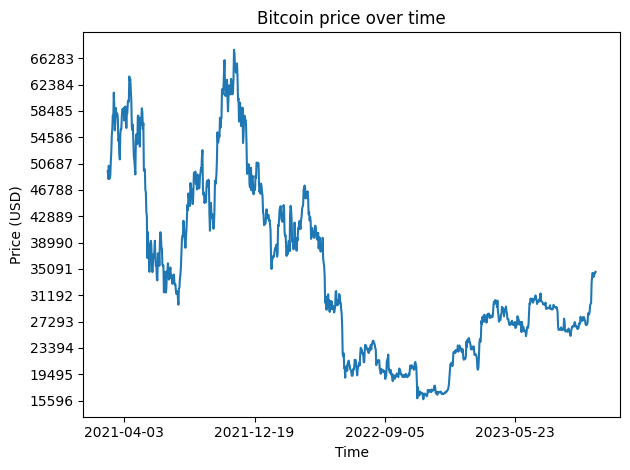

In [10]:
#Dados binance
plt.plot(df1.close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
#plt.savefig("initial_plot.png", dpi=250)
ax = plt.gca()  # Get the current axes
ay = plt.gca()
nx = len(train_data.close) // 3  # Display approximately 10 x-ticks
ny = len(train_data.close) // 0.2  # Display approximately 10 x-ticks
ax.xaxis.set_major_locator(MultipleLocator(nx))
ay.yaxis.set_major_locator(MultipleLocator(ny))
plt.tight_layout()
plt.show()


39


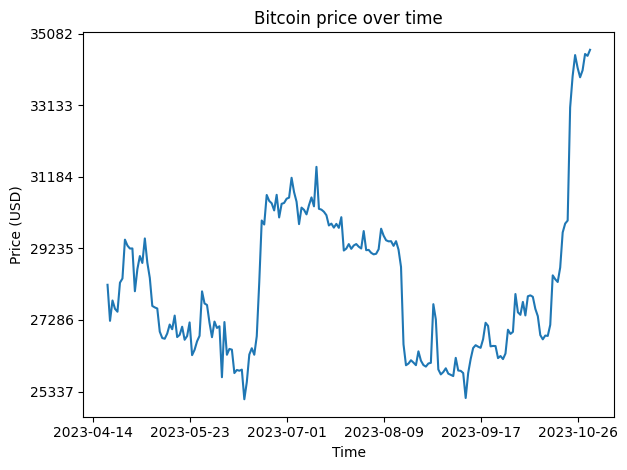

In [11]:
#Dados de test
plt.plot(test_data.close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price for testing")
ax_test = plt.gca()  # Get the current axes
ay_test = plt.gca()
nx_test = len(test_data.close) // 5  # Display approximately 10 x-ticks
ny_test = len(test_data.close) // 0.1  # Display approximately 10 x-ticks
print(nx_test)
ax_test.xaxis.set_major_locator(MultipleLocator(nx_test))
ay_test.yaxis.set_major_locator(MultipleLocator(ny_test))
plt.tight_layout()
plt.show()

156


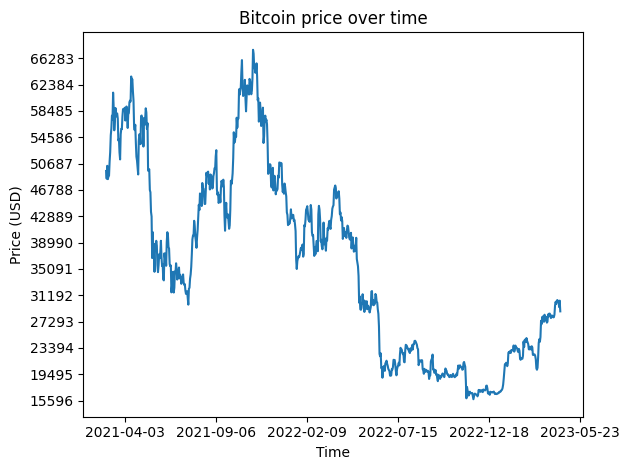

In [18]:
#Dados de treinamento
plt.plot(train_data.close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price for training")
ax_train = plt.gca()  # Get the current axes
ay_train = plt.gca()
nx_train = len(train_data.close) // 5  # Display approximately 10 x-ticks
ny_train = len(train_data.close) // 0.2  # Display approximately 10 x-ticks
print(nx_train)
ax_train.xaxis.set_major_locator(MultipleLocator(nx_train))
ay_train.yaxis.set_major_locator(MultipleLocator(ny_train))
plt.tight_layout()
plt.show()

In [40]:
X, y = train_data.drop(columns=['close']), train_data.close.values
X.shape, y.shape

((780, 4), (780,))

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [42]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

(632, 100, 4) (632, 50)


In [43]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()
y_mm[0]

array([0.34012323, 0.41756599, 0.40379971, 0.4164824 , 0.38196919,
       0.4491156 , 0.47802145, 0.47082745, 0.43613722, 0.43118907,
       0.38725922, 0.38076346, 0.38301374, 0.30588039, 0.3232857 ,
       0.34586799, 0.3649042 , 0.3054073 , 0.31891983, 0.36562408,
       0.36165362, 0.38903506, 0.37228488, 0.3425173 , 0.34796444,
       0.36502093, 0.37695223, 0.34610125, 0.35634136, 0.34942489,
       0.33036181, 0.34852991, 0.34248212, 0.35709468, 0.33443799,
       0.32754142, 0.32928556, 0.31111901, 0.30153094, 0.30416311,
       0.30915861, 0.29101351, 0.27073504, 0.31623085, 0.31900061,
       0.34501804, 0.35707825, 0.37877871, 0.41465844, 0.45756673])

In [44]:
y_trans[99:149].squeeze(1)

array([0.34012323, 0.41756599, 0.40379971, 0.4164824 , 0.38196919,
       0.4491156 , 0.47802145, 0.47082745, 0.43613722, 0.43118907,
       0.38725922, 0.38076346, 0.38301374, 0.30588039, 0.3232857 ,
       0.34586799, 0.3649042 , 0.3054073 , 0.31891983, 0.36562408,
       0.36165362, 0.38903506, 0.37228488, 0.3425173 , 0.34796444,
       0.36502093, 0.37695223, 0.34610125, 0.35634136, 0.34942489,
       0.33036181, 0.34852991, 0.34248212, 0.35709468, 0.33443799,
       0.32754142, 0.32928556, 0.31111901, 0.30153094, 0.30416311,
       0.30915861, 0.29101351, 0.27073504, 0.31623085, 0.31900061,
       0.34501804, 0.35707825, 0.37877871, 0.41465844, 0.45756673])

In [45]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-30]
X_test = X_ss[-30:]

y_train = y_mm[:-30]
y_test = y_mm[-30:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (602, 100, 4) (602, 50)
Testing Shape: (30, 100, 4) (30, 50)


In [10]:
# # convert to pytorch tensors
# X_train_tensors = torch.tensor(X_train)
# X_test_tensors = torch.tensor(X_test)
# y_train_tensors = torch.tensor(y_train)
# y_test_tensors = torch.tensor(y_test)

In [47]:
# # reshaping to rows, timestamps, features
# X_train_tensors_final = torch.reshape(X_train_tensors,   
#                                       (X_train_tensors.shape[0], 100, 
#                                        X_train_tensors.shape[2]))
# X_test_tensors_final = torch.reshape(X_test_tensors,  
#                                      (X_test_tensors.shape[0], 100, 
#                                       X_test_tensors.shape[2])) 
# convert to pytorch tensors
X_train_tensors_final = torch.tensor(X_train, dtype=torch.float32)
X_test_tensors_final = torch.tensor(X_test, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train, dtype=torch.float32)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32)

# reshaping to batch_size, seq_len, input_size
X_train_tensors_final = X_train_tensors_final.view(-1, 100, 4)
X_test_tensors_final = X_test_tensors_final.view(-1, 100, 4)

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([602, 100, 4]) torch.Size([602, 50])
Testing Shape: torch.Size([30, 100, 4]) torch.Size([30, 50])


In [48]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]

array([[ 15781.29   ,  16315.     ,  15616.63   , 239548.06623],
       [ 16227.96   ,  16706.     ,  16160.2    , 264927.70408],
       [ 16603.11   ,  16812.63   ,  16458.05   , 206565.92346],
       [ 16599.55   ,  16666.     ,  16342.81   , 182089.49533]])

In [49]:
X.iloc[-149:-145]

,open,high,low,volume
timestamp,,,,
2022-11-22,15781.29,16315.00,15616.63,239548.06623
2022-11-23,16227.96,16706.00,16160.20,264927.70408
2022-11-24,16603.11,16812.63,16458.05,206565.92346
2022-11-25,16599.55,16666.00,16342.81,182089.49533


In [50]:
y_check[-1]

array([23628.97, 23465.32, 22354.34, 22346.57, 22430.24, 22410.  ,
       22197.96, 21705.44, 20362.22, 20150.69, 20455.73, 21997.11,
       24113.48, 24670.41, 24285.66, 24998.78, 27395.13, 26907.49,
       27972.87, 27717.01, 28105.47, 27250.97, 28295.41, 27454.47,
       27462.95, 27968.05, 27124.91, 27261.07, 28348.6 , 28028.53,
       28465.36, 28452.73, 28171.87, 27800.  , 28165.47, 28170.01,
       28033.82, 27906.33, 27938.38, 28323.76, 29637.34, 30200.42,
       29888.07, 30373.84, 30466.93, 30295.09, 30304.65, 29430.27,
       30380.01, 28797.1 ])

In [51]:
train_data.close.values[-50:]

array([23628.97, 23465.32, 22354.34, 22346.57, 22430.24, 22410.  ,
       22197.96, 21705.44, 20362.22, 20150.69, 20455.73, 21997.11,
       24113.48, 24670.41, 24285.66, 24998.78, 27395.13, 26907.49,
       27972.87, 27717.01, 28105.47, 27250.97, 28295.41, 27454.47,
       27462.95, 27968.05, 27124.91, 27261.07, 28348.6 , 28028.53,
       28465.36, 28452.73, 28171.87, 27800.  , 28165.47, 28170.01,
       28033.82, 27906.33, 27938.38, 28323.76, 29637.34, 30200.42,
       29888.07, 30373.84, 30466.93, 30295.09, 30304.65, 29430.27,
       30380.01, 28797.1 ])

In [52]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [53]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 

In [54]:
warnings.filterwarnings('ignore')

n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [55]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [56]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.22202, test loss: 0.05764
Epoch: 100, train loss: 0.02377, test loss: 0.00592
Epoch: 200, train loss: 0.01854, test loss: 0.00844
Epoch: 300, train loss: 0.01618, test loss: 0.00918
Epoch: 400, train loss: 0.01203, test loss: 0.00930
Epoch: 500, train loss: 0.01116, test loss: 0.01018
Epoch: 600, train loss: 0.01091, test loss: 0.01056
Epoch: 700, train loss: 0.01063, test loss: 0.01071
Epoch: 800, train loss: 0.01033, test loss: 0.01084
Epoch: 900, train loss: 0.01009, test loss: 0.01089


Current shape of input data: (632, 100, 4)


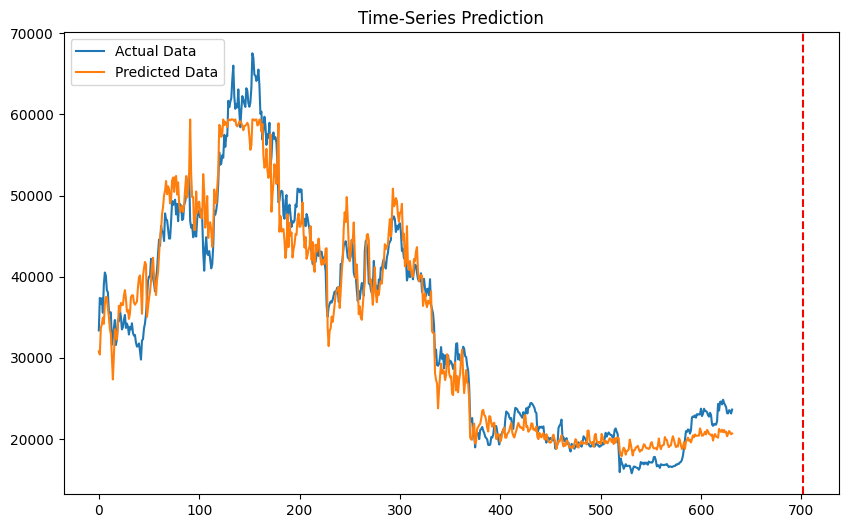

In [57]:
df_X_ss = ss.transform(train_data.drop(columns=['close'])) # old transformers
df_y_mm = mm.transform(train_data.close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)

# Print the current shape of input data
print("Current shape of input data:", df_X_ss.shape)

# Adjust the reshaping if the shape doesn't match the expected size
expected_shape = (df_X_ss.shape[0], 100, df_X_ss.shape[2])
if df_X_ss.shape != expected_shape:
    df_X_ss = df_X_ss.reshape(expected_shape)

# converting to tensors
df_X_ss = torch.tensor(df_X_ss, dtype=torch.float32)
df_y_mm = torch.tensor(df_y_mm, dtype=torch.float32)

# forward pass through LSTM
train_predict = lstm(df_X_ss)
data_predict = mm.inverse_transform(train_predict.squeeze().detach().numpy())
dataY_plot = mm.inverse_transform(df_y_mm.numpy())

true = dataY_plot[:, 0]
preds = data_predict[:, 0]

plt.figure(figsize=(10, 6))
plt.axvline(x=train_test_cutoff, c='r', linestyle='--')

plt.plot(true, label='Actual Data')
plt.plot(preds, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()